In [13]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 8
num_itr = 40
K = 50
max_inner = 40
train_depth = 10
adam_lr = 0.1

In [5]:
A = np.random.randn(n,n)
A = A.T @ A
A = A/LA.norm(A)
eig, _ = LA.eig(np.eye(len(A)) - A)
lambda_min = min(eig)
lambda_max = max(eig)
omega_opt = 2/(lambda_min + lambda_max)

In [38]:
A = jnp.array(A)
@jax.jit
def gen_x_fixed(b):
    return JLA.inv((np.eye(len(A)) - A)) @ b
batch_gen_x_fixed = jax.vmap(gen_x_fixed, in_axes=-1, out_axes=-1)

In [39]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [40]:
@partial(jax.jit, static_argnums=0)
def fixed_point_itr(max_itr, b):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x = A@x + b
    return x        

In [41]:
@partial(jax.jit, static_argnums=0)
def SOR_itr(max_itr, b):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x += omega_opt * (A@x + b - x)
    return x

In [42]:
def comp_mse(max_itr, func):
    se = 0.0
    b = jnp.array(np.random.randn(n, K))
    x_fixed = batch_gen_x_fixed(b)
    x_hat = func(max_itr, b)
    return jnp.sum(batch_get_dot(x_hat - x_fixed))/K

In [43]:
org_mes = [comp_mse(i+1, fixed_point_itr) for i in range(num_itr)]
SOR_mes = [comp_mse(i+1, SOR_itr) for i in range(num_itr)]

In [44]:
df = pd.DataFrame()
df["Iteration"] = range(num_itr)
df["Original fixed-point iteration"] = np.array(org_mes)
df["SOR Iteration"] = np.array(SOR_mes)

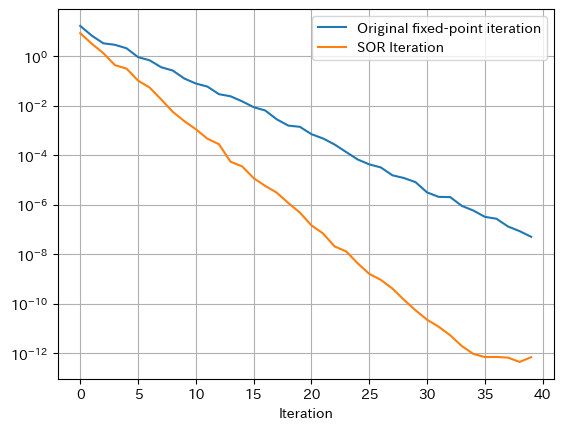

In [45]:
df.plot(df.columns[0], df.columns[1:])
plt.yscale("log")
plt.grid()